## 4. Predictive Analysis 

In [1]:
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

# Read data from the data folder
race_df = pd.read_csv('data/race.csv', low_memory=False, index_col=0)
horse_df = pd.read_csv('data/horse.csv', low_memory=False, index_col=0)
individual_df = pd.read_csv('data/individual.csv', low_memory=False, index_col=0)
trainer_df = pd.read_csv('data/trainer.csv', low_memory=False, index_col=0)
jockey_df = pd.read_csv('data/jockey.csv', low_memory=False, index_col=0)
horse_race_df = pd.read_csv('data/horse_race.csv', low_memory=False, index_col=0)
horse_race_df['age_int'] = horse_race_df['sex_age'].apply(lambda x: re.search(r'\d+', x).group(0)).astype(int)

# Do some simple data transformation
horse_race_df['run_date'] = horse_race_df['run_date'].apply(pd.Timestamp)
horse_race_df = horse_race_df.sort_values(['horse_id', 'run_date'])
try:
    first_occur_df = pd.read_csv('data/first_occurence_race.csv', low_memory=False, index_col=0)
    first_occur_df['run_date'] = first_occur_df['run_date'].apply(pd.Timestamp)
except FileNotFoundError:
    horse_race_sorted = horse_race_df.copy()
    horse_id_set = set()
    first_occur_dict = {}
    for index, value in horse_race_sorted.iterrows():
        if value['horse_id'] not in horse_id_set:
            horse_id_set.add(value['horse_id'])
            first_occur_dict[index] = value
    first_occur_df = pd.DataFrame.from_dict(first_occur_dict, orient='index')
    first_occur_df.to_csv('data/first_occurence_race.csv', encoding='utf-8')
    
columns_to_drop = [
    'race', 'title', 'horse', 'sex_age',
    'distance', 'run_time', 'breeder',
    'jockey', 'margin', 'trainer_x', 'trainer_y', 'owner_x', 'owner_y', 'horse_name', 'date_of_birth', 
    'transaction_price', 'prize_obtained', 'race_record', 'highlight_race', 'relatives', 'status', 'prize'
]
for column in columns_to_drop:
    try:
        first_occur_df.drop(column, axis=1, inplace=True)
        horse_race_df.drop(column, axis=1, inplace=True)
    except ValueError:
        continue
        
horse_race_df = horse_race_df[horse_race_df['finishing_position'].apply(lambda x: bool(re.search(r'\d+', x)))]
horse_race_df['finishing_position'] = horse_race_df['finishing_position'].apply(lambda x: re.search(r'\d+', x).group(0))
horse_race_df['finishing_position'] = horse_race_df['finishing_position'].astype(int)

C:\Users\terry\Anaconda3\lib\site-packages\cmocean\tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
C:\Users\terry\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

## 4.1 Feature Engineering 

In [3]:
def get_dummies_order_by_count(df, column_name):
    # Get dummies by descending count order
    return pd.get_dummies(df[column_name]).reindex(df[column_name].value_counts().index, axis=1).iloc[:, :-1]

def parse_time_stamp(time_string):
    # Parse timestamp expressed in hours
    time_split = time_string.split(':')
    hour = int(time_split[0])
    if hour < 12:
        return '10-12'
    elif hour > 12 and hour < 15:
        return '12-15'
    else:
        return '15-after'
    
def get_trainer_jockey_profile(df, individual):
    # Merge with trainer/jockey dataframe
    assert individual in ['trainer', 'jockey']
    if individual == 'trainer':
        merge_df = trainer_df
    elif individual == 'jockey':
        merge_df = jockey_df
    df = df.merge(merge_df[['%s_id' % individual, 'date_of_birth', 'place_of_birth']], 
                  on='%s_id' % individual, suffixes=['', '_%s' % individual])
    df['run_date'] = df['run_date'].apply(lambda x: pd.Timestamp(x))
    df['date_of_birth'] = df['date_of_birth'].apply(lambda x: pd.Timestamp(x))
    df['%s_age' % individual] = df['run_date'].subtract(df['date_of_birth']).dt.days / 365.0
    df.drop(['date_of_birth'], axis=1, inplace=True)
    df['place_of_birth_%s' % individual] = df['place_of_birth_%s' % individual].apply(lambda x: 'tokyo' if x == u'東京都' \
                                                                                      else 'outside_tokyo')
    return df

def feature_engineer(race_df, dummy=True, drop_columns=True):
    
    new_df = race_df.copy()

    # Feature engineering
    has_horse_weight = new_df['horse_weight'].apply(lambda x: bool(re.search(r'(\d+)\(.+\)', x)))
    new_df = new_df[has_horse_weight]
    new_df['horse_weight_increase'] = new_df['horse_weight'].apply(lambda x: re.search(r'\(.?(\d+)\)', x).group(1))
    new_df['horse_weight_increase'] = new_df['horse_weight_increase'].astype(float)
    new_df['horse_weight'] = new_df['horse_weight'].apply(lambda x: re.search(r'(\d+)\(.+\)', x).group(1))
    new_df['horse_weight'] = new_df['horse_weight'].astype(float)

    new_df['time'] = new_df['time'].apply(lambda x: parse_time_stamp(x))

    for individual in ['jockey', 'trainer']:
        new_df = get_trainer_jockey_profile(new_df, individual)

    # Get dummy columns
    if dummy:
        dummied_cols = ['place', 'type', 'track', 'weather', 'condition', 'gender', 'breed', 'bracket', 'horse_number', 
                        'time', 'place_of_birth_jockey', 'place_of_birth_trainer']
        for cols in dummied_cols:
            new_df = new_df.join(get_dummies_order_by_count(new_df, 
                                                           cols).rename(columns=lambda x: '-'.join([cols, str(x)])))
            try:
                new_df.drop(cols, axis=1, inplace=True)
            except ValueError:
                continue

    # Drop some other columns
    columns_to_drop_again = ['finishing_position', 'corner_position', 'run_time_last_600', 
                             'jockey_id', 'owner_id', 'trainer_id', 'breeder_id', 
                             'parents', 'age_int', 'place_of_birth']
    if drop_columns:
        for cols in columns_to_drop_again:
            try:
                new_df.drop(cols, axis=1, inplace=True)
            except ValueError:
                continue
    
    return new_df.sort_values(['horse_id', 'run_date']).set_index(['horse_id', 'run_date'])

## 4.2 Regression Analysis

### 4.2.1 OLS for First Occurence Race

In [4]:
new_df_first = feature_engineer(first_occur_df)
X_first = new_df_first.loc[:, new_df_first.columns != 'run_time_1000']
y_first = new_df_first.loc[:, 'run_time_1000']
X_first = sm.add_constant(X_first)
results = sm.OLS(y_first, X_first).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          run_time_1000   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     971.6
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        12:45:39   Log-Likelihood:            -1.7226e+05
No. Observations:               86622   AIC:                         3.446e+05
Df Residuals:                   86555   BIC:                         3.453e+05
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   60.2242      0.633     95.151      0.000      58.984      61.465
jockey_weight                            0.0838      0.007     12.578      0.000       0.071       0.097
win_odds                                 0.0003      0.000      2.471      0.013    5.54e-05       0.000
win_fav                                  0.1028      0.002     45.776      0.000       0.098       0.107
horse_weight                             0.0074      0.000     33.384      0.000       0.007       0.008
curr_age                                -0.2335      0.013    -17.429      0.000      -0.260      -0.207
horse_weight_increase                   -0.0534      0.002    -25.199      0.000      -0.058      -0.049
jockey_age                              -0.0042      0.001     -4.859      0.000      -0.006      -0.002
trainer_age                             -0.0024      0.001     -3.542      0.000      -0.004      -0.001
place-中山                                 0.9802      0.037     26.680      0.000       0.908       1.052
place-京都                                 0.2527      0.036      6.929      0.000       0.181       0.324
place-東京                                 0.1641      0.261      0.628      0.530      -0.348       0.676
place-阪神                                 0.3444      0.037      9.277      0.000       0.272       0.417
place-新潟                                -0.1590      0.262     -0.606      0.545      -0.673       0.355
place-小倉                                -0.3745      0.040     -9.347      0.000      -0.453      -0.296
place-福島                                 0.2976      0.041      7.310      0.000       0.218       0.377
place-中京                                 0.0286      0.263      0.109      0.913      -0.486       0.544
place-札幌                                 0.3523      0.044      8.007      0.000       0.266       0.439
type-芝                                  -5.5165      0.100    -54.938      0.000      -5.713      -5.320
type-ダ                                  -3.0927      0.100    -30.953      0.000      -3.289      -2.897
track-右                                 -2.1478      0.135    -15.903      0.000      -2.413      -1.883
track-左                                 -1.7711      0.143    -12.428      0.000      -2.050      -1.492
track-直                                 -4.6903      0.160    -29.390      0.000      -5.003      -4.377
weather-晴                               -1.0084      0.203     -4.959      0.000      -1.407      -0.610
weather-曇                               -1.0341      0.204     -5.081      0.000      -1.433      -0.635
weather-雨                               -0.5828      0.205     -2.842      0.004      -0.985      -0.181
weather-小雨                            

### 4.2.2 OLS for Full Race

In [5]:
new_df_full = feature_engineer(horse_race_df)
X_full = new_df_full.loc[:, new_df_full.columns != 'run_time_1000']
y_full = new_df_full.loc[:, 'run_time_1000']
X_full = sm.add_constant(X_full)
results = sm.OLS(y_full, X_full).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          run_time_1000   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                 1.635e+04
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        12:48:52   Log-Likelihood:            -1.6583e+06
No. Observations:              857855   AIC:                         3.317e+06
Df Residuals:                  857788   BIC:                         3.317e+06
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   44.6347      0.142    314.697      0.000      44.357      44.913
jockey_weight                            0.0207      0.002     13.127      0.000       0.018       0.024
win_odds                                 0.0015   2.91e-05     51.592      0.000       0.001       0.002
win_fav                                  0.0670      0.001    106.068      0.000       0.066       0.068
horse_weight                             0.0019   7.04e-05     26.474      0.000       0.002       0.002
curr_age                                -0.3122      0.002   -174.727      0.000      -0.316      -0.309
horse_weight_increase                   -0.0095      0.000    -24.545      0.000      -0.010      -0.009
jockey_age                              -0.0038      0.000    -15.223      0.000      -0.004      -0.003
trainer_age                             -0.0036      0.000    -17.275      0.000      -0.004      -0.003
place-東京                                -0.7808      0.023    -33.403      0.000      -0.827      -0.735
place-京都                                -0.2908      0.010    -29.075      0.000      -0.310      -0.271
place-中山                                 0.3292      0.010     32.565      0.000       0.309       0.349
place-阪神                                -0.1360      0.010    -13.467      0.000      -0.156      -0.116
place-新潟                                -0.8478      0.024    -35.838      0.000      -0.894      -0.801
place-中京                                -0.4896      0.024    -20.548      0.000      -0.536      -0.443
place-小倉                                -0.4753      0.011    -44.243      0.000      -0.496      -0.454
place-福島                                 0.0118      0.011      1.089      0.276      -0.009       0.033
place-札幌                                -0.0427      0.012     -3.520      0.000      -0.066      -0.019
type-ダ                                  12.8745      0.048    267.683      0.000      12.780      12.969
type-芝                                  10.5935      0.048    221.138      0.000      10.500      10.687
track-右                                  2.7598      0.030     93.284      0.000       2.702       2.818
track-左                                  3.4127      0.021    164.245      0.000       3.372       3.453
track-芝                                 21.1667      0.051    413.546      0.000      21.066      21.267
weather-晴                               -1.0103      0.064    -15.803      0.000      -1.136      -0.885
weather-曇                               -1.0103      0.064    -15.792      0.000      -1.136      -0.885
weather-雨                               -0.6344      0.064     -9.857      0.000      -0.761      -0.508
weather-小雨                            

In [6]:
horse_race_df_grp_by = horse_race_df.set_index(['horse_id', 'run_date'])
horse_race_df_grp_by['run_time_diff'] = horse_race_df_grp_by['run_time_1000'].diff()
horse_race_df_grp_by = horse_race_df_grp_by[~horse_race_df_grp_by.index.isin(first_occur_df.set_index(['horse_id', 
                                                                                                       'run_date']).index)]
horse_race_df_grp_by.reset_index(inplace=True)
new_df_full_diff = feature_engineer(horse_race_df_grp_by)
new_df_full_diff['last_run_time'] = new_df_full_diff['run_time_1000'] - new_df_full_diff['run_time_diff']
new_df_full_diff.drop('run_time_diff', inplace=True, axis=1)

X_full_diff = new_df_full_diff.loc[:, new_df_full_diff.columns != 'run_time_1000']
y_full_diff = new_df_full_diff.loc[:, 'run_time_1000']
X_full_diff = sm.add_constant(X_full_diff)
results_diff = sm.OLS(y_full_diff, X_full_diff).fit()
results_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          run_time_1000   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                 2.045e+04
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        12:52:17   Log-Likelihood:            -1.4146e+06
No. Observations:              771242   AIC:                         2.829e+06
Df Residuals:                  771174   BIC:                         2.830e+06
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   30.5710      0.142    215.162      0.000      30.293      30.850
jockey_weight                            0.0078      0.001      5.235      0.000       0.005       0.011
win_odds                                 0.0009   2.76e-05     33.620      0.000       0.001       0.001
win_fav                                  0.0360      0.001     59.542      0.000       0.035       0.037
horse_weight                            -0.0004   6.79e-05     -5.214      0.000      -0.000      -0.000
curr_age                                -0.1599      0.002    -91.514      0.000      -0.163      -0.156
horse_weight_increase                    0.0021      0.000      5.620      0.000       0.001       0.003
jockey_age                              -0.0026      0.000    -10.811      0.000      -0.003      -0.002
trainer_age                             -0.0015      0.000     -7.381      0.000      -0.002      -0.001
place-東京                                -0.6830      0.021    -31.893      0.000      -0.725      -0.641
place-京都                                -0.2069      0.009    -21.801      0.000      -0.225      -0.188
place-中山                                 0.2919      0.010     30.451      0.000       0.273       0.311
place-阪神                                -0.0586      0.010     -6.127      0.000      -0.077      -0.040
place-新潟                                -0.7278      0.022    -33.568      0.000      -0.770      -0.685
place-中京                                -0.3550      0.022    -16.258      0.000      -0.398      -0.312
place-小倉                                -0.3762      0.010    -37.063      0.000      -0.396      -0.356
place-福島                                -0.0144      0.010     -1.402      0.161      -0.035       0.006
place-函館                                 0.1050      0.011      9.138      0.000       0.082       0.127
type-ダ                                   8.6148      0.048    180.432      0.000       8.521       8.708
type-芝                                   6.7773      0.047    143.318      0.000       6.685       6.870
track-右                                  2.4738      0.027     90.739      0.000       2.420       2.527
track-左                                  3.0292      0.019    155.944      0.000       2.991       3.067
track-芝                                 15.1789      0.052    293.239      0.000      15.077      15.280
weather-晴                               -0.8307      0.062    -13.435      0.000      -0.952      -0.710
weather-曇                               -0.8228      0.062    -13.299      0.000      -0.944      -0.702
weather-雨                               -0.4431      0.062     -7.120      0.000      -0.565      -0.321
weather-小雨                            

## 4.3 Regression Models

In [7]:
max_window = 3
try:
    df_combined = pd.read_csv('data/horse_race_combined.csv', low_memory=False, index_col=0)
    df_combined['run_date'] = df_combined['run_date'].apply(lambda x: pd.Timestamp(x))
    df_combined = df_combined.sort_values(['horse_id', 'run_date'])
    
    df_combined = df_combined.iloc[:30000]
    
    df_combined.set_index(['horse_id', 'run_date'], inplace=True)
    df_combined = df_combined[~df_combined.index.isin(first_occur_df.sort_values(['horse_id', 'run_date']).set_index(['horse_id', 'run_date']).index)]
except FileNotFoundError:
    df_combined = horse_race_df.set_index(['horse_id', 'run_date'])
    df_combined['run_time_diff'] = df_combined['run_time_1000'].diff()
    df_combined['last_run_time'] = df_combined['run_time_1000'] - df_combined['run_time_diff']
    df_combined['run_time_quo'] = df_combined['run_time_1000'] / df_combined['last_run_time']
    df_combined['run_time_mean'] = df_combined['last_run_time']

    df_reset = df_combined['run_time_mean'].reset_index()
    horse_id_lst = list(df_reset['horse_id'])
    run_time_mean_lst = list(df_reset['run_time_mean'])
    new_run_time_mean_lst = []
    new_run_time_median_lst = []
    curr_index = horse_id_lst[0]
    curr_count = 0
    curr_sum = 0
    curr_stored = []
    for index, value in zip(horse_id_lst, run_time_mean_lst):
        if index != curr_index:
            curr_count = 1
            curr_sum = value
            curr_index = index
            curr_stored = [value]
        else:
            curr_count += 1
            curr_sum += value
            curr_stored.append(value)
        new_run_time_mean_lst.append(curr_sum / (curr_count * 1.0))
        new_run_time_median_lst.append(np.median(curr_stored))
    df_combined['run_time_mean'] = pd.Series(new_run_time_mean_lst, index=df_combined.index)
    df_combined['run_time_median'] = pd.Series(new_run_time_median_lst, index=df_combined.index)

    for window in range(2, max_window + 1):
        ma = df_combined.groupby(level=0)['run_time_1000'].rolling(window).mean().groupby(level=0).shift(1)
        ma = ma.reset_index(level=1)['run_time_1000'].reset_index()
        ewma = df_combined.groupby(level=0)['run_time_1000'].apply(lambda series: series.ewm(ignore_na=True, 
                                                                                             min_periods=window, 
                                                                                             adjust=True,
                                                                                             com=0.030927835051546).mean())
        ewma = ewma.groupby(level=0).shift(1)
        df_combined['run_time_ma_window_%s' % str(window)] = ma.set_index(['horse_id', 'run_date'])['run_time_1000']
        df_combined['run_time_ewma_window_%s' % str(window)] = ewma
    df_combined.reset_index().to_csv('data/horse_race_combined.csv', encoding='utf-8')

dependent = ['run_time_1000',
             'run_time_diff', 'run_time_quo', 
             'run_time_mean', 'run_time_median'] + \
            ['run_time_ma_window_%s' % str(idx) for idx in range(2, max_window + 1)] + \
            ['run_time_ewma_window_%s' % str(idx) for idx in range(2, max_window + 1)]
df_combined_y = df_combined[dependent].copy()
df_combined_x = df_combined[list(filter(lambda x: x not in dependent, df_combined.columns))].copy()
df_y_original_dict = {}
df_y_original_dict['run_time_diff'] = df_combined_x['last_run_time']
df_y_original_dict['run_time_quo'] = df_combined_x['last_run_time']
for col_name in dependent[3:]:
    df_combined_y[col_name + '_diff'] = df_combined_y['run_time_1000'] - df_combined_y[col_name]
    df_combined_y[col_name + '_quo'] = df_combined_y['run_time_1000'] / df_combined_y[col_name]
    df_y_original_dict[col_name + '_diff'] = df_combined_y[col_name]
    df_y_original_dict[col_name + '_quo'] = df_combined_y[col_name]
    df_combined_y.drop(col_name, axis=1, inplace=True)

In [8]:
df_combined_y[list(filter(lambda x: 'diff' in x or 'quo' in x, df_combined_y.columns))].T

horse_id                             1986102130          1989107128  \
run_date                    2000-01-29 15:40:00 2000-02-05 13:45:00   
run_time_diff                          1.642857           -1.146258   
run_time_quo                           1.027381            0.983224   
run_time_mean_diff                          NaN            2.547192   
run_time_mean_quo                           NaN            1.039409   
run_time_median_diff                        NaN            2.547192   
run_time_median_quo                         NaN            1.039409   
run_time_ma_window_2_diff                   NaN                 NaN   
run_time_ma_window_2_quo                    NaN                 NaN   
run_time_ma_window_3_diff                   NaN                 NaN   
run_time_ma_window_3_quo                    NaN                 NaN   
run_time_ewma_window_2_diff                 NaN                 NaN   
run_time_ewma_window_2_quo                  NaN                 NaN   
run_time_ewma_window_3_diff                 NaN                 NaN   
run_time_ewma_window_3_quo                  NaN                 NaN   

horse_id                                                             \
run_date                    2000-03-11 15:10:00 2000-04-15 15:30:00   
run_time_diff                          0.510490            2.697936   
run_time_quo                           1.007599            1.039856   
run_time_mean_diff                     2.208618            4.354399   
run_time_mean_quo                      1.033728            1.065940   
run_time_median_diff                   0.510490            2.953181   
run_time_median_quo                    1.007599            1.043792   
run_time_ma_window_2_diff             -0.062639            2.953181   
run_time_ma_window_2_quo               0.999076            1.043792   
run_time_ma_window_3_diff                   NaN            2.656177   
run_time_ma_window_3_quo                    NaN            1.039215   
run_time_ewma_window_2_diff            0.477103            2.712237   
run_time_ewma_window_2_quo             1.007098            1.040076   
run_time_ewma_window_3_diff                 NaN            2.712237   
run_time_ewma_window_3_quo                  NaN            1.040076   

horse_id                             1990104469                      \
run_date                    2000-03-18 11:45:00 2000-04-15 15:30:00   
run_time_diff                          1.279356            1.830030   
run_time_quo                           1.019112            1.026826   
run_time_mean_diff                    -0.446069            1.532651   
run_time_mean_quo                      0.993504            1.022369   
run_time_median_diff                  -0.446069            1.830030   
run_time_median_quo                    0.993504            1.026826   
run_time_ma_window_2_diff                   NaN            2.469709   
run_time_ma_window_2_quo                    NaN            1.036545   
run_time_ma_window_3_diff                   NaN                 NaN   
run_time_ma_window_3_quo                    NaN                 NaN   
run_time_ewma_window_2_diff                 NaN            1.867293   
run_time_ewma_window_2_quo                  NaN            1.027387   
run_time_ewma_window_3_diff                 NaN                 NaN   
run_time_ewma_window_3_quo                  NaN                 NaN   

horse_id                             1991100019                      \
run_date                    2000-02-12 15:45:00 2000-03-19 15:00:00   
run_time_diff                          0.214286           -1.160714   
run_time_quo                           1.003567            0.980746   
run_time_mean_diff                    -4.396341           -4.091609   
run_time_mean_quo                      0.932032            0.935276   
run_time_median_diff                  -4.396341           -1.160714   
run_time_median_quo                    0.932032            0.980746   
run_time_ma_window_2_

In [9]:
# Model testing for run time residual
x = feature_engineer(df_combined_x.reset_index())
x = x.drop('last_run_time', axis=1)
y = df_combined_y.loc[df_combined_y.index.isin(x.index), 'run_time_diff']

# OLS
reg = linear_model.LinearRegression(fit_intercept=False)
scores_reg = cross_val_score(reg, x, y, scoring='neg_mean_squared_error')
print("RMSE for OLS: %0.5f" % np.sqrt(-scores_reg.mean()))

RMSE for OLS: 1.90225


In [10]:
class ModelComparer(object): 
    
    no_drop_col = ['run_time_1000']
    
    def __init__(self, X_df, y_df, original_y_df_dict):
        self.X = feature_engineer(X_df.reset_index())
        self.y = y_df[y_df.index.isin(self.X.index)]
        self.y_original = original_y_df_dict
        self.run_time_serie = self.y['run_time_1000']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3)
        self.model_dict = {}
        
    def add_model(self, model_method, model_name):
        
        print('Adding model named %s ' % model_name)
        self.model_dict[model_name] = {}
        
        for y_col_name in self.y.columns:
            X_train = self.X_train.copy()
            X_test = self.X_test.copy()                
            model = model_method
            self.model_dict[model_name]['Model Spec'] = repr(model)
            
            if y_col_name not in self.no_drop_col:
                X_train.drop('last_run_time', axis=1, inplace=True)
                X_test.drop('last_run_time', axis=1, inplace=True)
                
            y_train = self.y_train[y_col_name].dropna()
            y_test = self.y_test[y_col_name].dropna()
            
            X_train = X_train[X_train.index.isin(y_train.index)]
            X_test = X_test[X_test.index.isin(y_test.index)]
                     
            if 'normalized' in model_name.lower():
                scaler = StandardScaler()
                scaler.fit(X_train)
                X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
                X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)
            
            print('Performing analysis on column %s for model %s (Size: %s)' % (y_col_name, model_name, str(X_train.shape)))
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            if y_col_name not in self.no_drop_col:
                y_pred = pd.Series(y_pred, index=X_test.index)
                original_serie = df_y_original_dict[y_col_name]
                original_serie = original_serie[original_serie.index.isin(y_pred.index)]
                run_time_serie = self.run_time_serie[self.run_time_serie.index.isin(y_pred.index)]
                if 'quo' in y_col_name:
                    y_pred = y_pred * original_serie
                elif 'diff' in y_col_name:
                    y_pred = y_pred + original_serie
                self.model_dict[model_name]['Transformed RMSE: %s (%s)' % (y_col_name, 
                                                                           X_train.shape[0])] = '%.6f' % self.get_rmse(y_pred, 
                                                                                                                       run_time_serie)  
            else:
                self.model_dict[model_name]['Original RMSE: %s (%s)' % (y_col_name, 
                                                                        X_train.shape[0])] = '%.6f' % self.get_rmse(y_pred, 
                                                                                                                    y_test)
        
    def get_report(self):
        try:
            df = pd.DataFrame.from_dict(self.model_dict)
            return df.sort_values(df.columns[0])
        except IndexError:
            return
    
    @staticmethod
    def get_rmse(y_true, y_pred):
        diff = np.sum((y_true - y_pred) ** 2)
        return (diff / y_true.shape[0]) ** 1/2
    
mc = ModelComparer(df_combined_x, df_combined_y, df_y_original_dict)

In [11]:
def get_ols(**kwargs):
    reg = linear_model.LinearRegression(**kwargs)
    return reg

def get_xgboost(**kwargs):
    xgb_model = xgb.XGBRegressor(**kwargs)
    return xgb_model

def get_decision_tree(**kwargs):
    dt = DecisionTreeRegressor(**kwargs)
    return dt

def get_random_forest(**kwargs):
    regr = RandomForestRegressor(**kwargs)
    return regr

def get_gbm(**kwargs):
    clf = GradientBoostingRegressor(**kwargs)
    return clf

def get_ann(**kwargs):
    mlp = MLPRegressor(**kwargs)
    return mlp

# Add base model
mc.add_model(get_ols(fit_intercept=False), 'OLS - Base Model')
mc.add_model(get_xgboost(learning_rate=0.1), 'XGB - Base Model (0.1LR)')
mc.add_model(get_decision_tree(max_depth=6), 'DT - Base Model (6MD)')
mc.add_model(get_random_forest(max_depth=6), 'RF - Base Model (6MD)')
mc.add_model(get_gbm(n_estimators=500, max_depth=6, min_samples_split=2, learning_rate=0.1, loss='ls'), 'GBM - Base Model (6MD, 0.1LR)')
mc.add_model(get_ann(max_iter=100000, learning_rate_init=0.02, hidden_layer_sizes=(300, 300, 300)), 'ANN - Base Model (normalized, 100000MI, 0.02LR, 300**3HL)')

Adding model named OLS - Base Model 
Performing analysis on column run_time_1000 for model OLS - Base Model (Size: (18996, 68))
Performing analysis on column run_time_diff for model OLS - Base Model (Size: (18996, 67))
Performing analysis on column run_time_quo for model OLS - Base Model (Size: (18996, 67))
Performing analysis on column run_time_mean_diff for model OLS - Base Model (Size: (18995, 67))
Performing analysis on column run_time_mean_quo for model OLS - Base Model (Size: (18995, 67))
Performing analysis on column run_time_median_diff for model OLS - Base Model (Size: (18995, 67))
Performing analysis on column run_time_median_quo for model OLS - Base Model (Size: (18995, 67))
Performing analysis on column run_time_ma_window_2_diff for model OLS - Base Model (Size: (17169, 67))
Performing analysis on column run_time_ma_window_2_quo for model OLS - Base Model (Size: (17169, 67))
Performing analysis on column run_time_ma_window_3_diff for model OLS - Base Model (Size: (15560, 67

Performing analysis on column run_time_diff for model ANN - Base Model (normalized, 100000MI, 0.02LR, 300**3HL) (Size: (18996, 67))
Performing analysis on column run_time_quo for model ANN - Base Model (normalized, 100000MI, 0.02LR, 300**3HL) (Size: (18996, 67))
Performing analysis on column run_time_mean_diff for model ANN - Base Model (normalized, 100000MI, 0.02LR, 300**3HL) (Size: (18995, 67))
Performing analysis on column run_time_mean_quo for model ANN - Base Model (normalized, 100000MI, 0.02LR, 300**3HL) (Size: (18995, 67))
Performing analysis on column run_time_median_diff for model ANN - Base Model (normalized, 100000MI, 0.02LR, 300**3HL) (Size: (18995, 67))
Performing analysis on column run_time_median_quo for model ANN - Base Model (normalized, 100000MI, 0.02LR, 300**3HL) (Size: (18995, 67))
Performing analysis on column run_time_ma_window_2_diff for model ANN - Base Model (normalized, 100000MI, 0.02LR, 300**3HL) (Size: (17169, 67))
Performing analysis on column run_time_ma_w

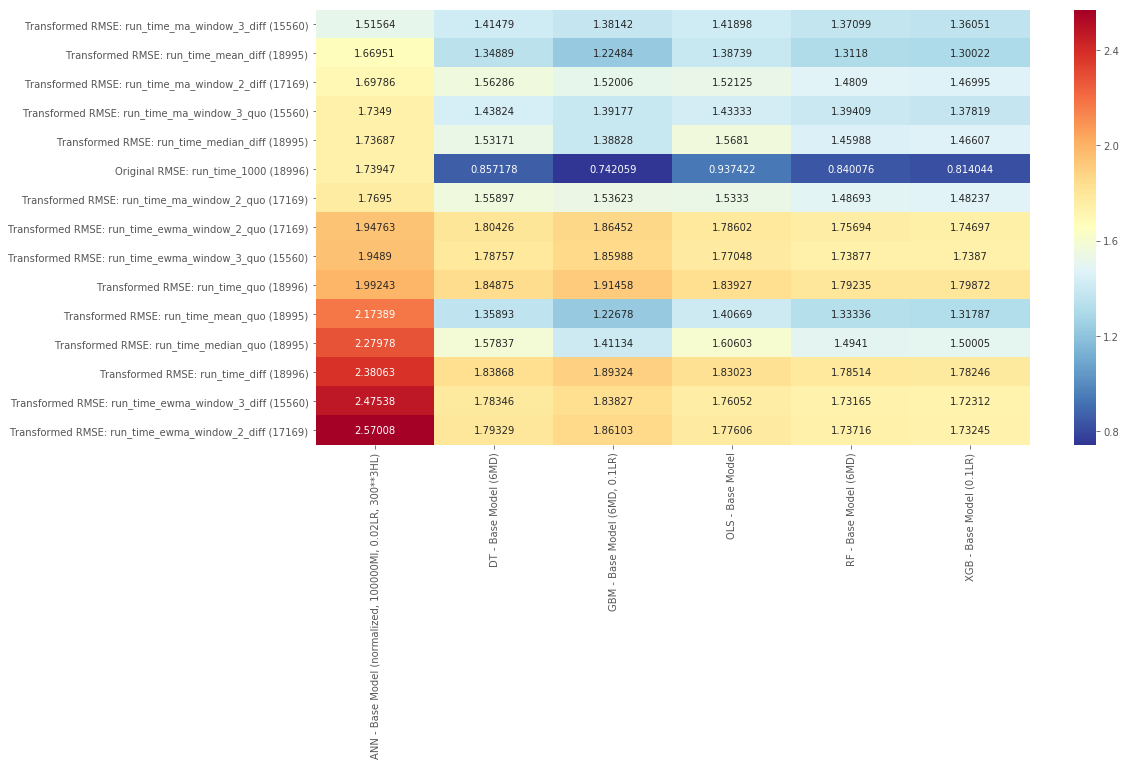

In [12]:
# Set some specs for plotting
mpl.rcParams['figure.figsize'] = (16.0, 8.0)
mpl.style.use('ggplot')

value_df = mc.get_report().dropna().iloc[:-1, :]
value_df = value_df.applymap(lambda x: float(x))
sns.heatmap(value_df, annot=True, fmt='g', cmap='RdYlBu_r')